<a href="https://colab.research.google.com/github/Pankaj-2003/Numerai_Models/blob/main/numerai_first_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q numerapi numpy pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 32.0 MB/s eta 0:00:00


In [3]:
%matplotlib inline

In [2]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()
all_datasets = napi.list_datasets()

In [3]:
dataset_versions = list(set([i.split("/")[0] for i in all_datasets]))
dataset_versions

['v4.1', 'v4', 'v4.3', 'v4.2']

In [4]:
dataset_version = "v4.3"
current_version_files = [i for i in all_datasets if i.startswith(dataset_version)]
current_version_files

['v4.3/features.json',
 'v4.3/live_benchmark_models.parquet',
 'v4.3/live_example_preds.csv',
 'v4.3/live_example_preds.parquet',
 'v4.3/live_int8.parquet',
 'v4.3/meta_model.parquet',
 'v4.3/train_benchmark_models.parquet',
 'v4.3/train_int8.parquet',
 'v4.3/validation_benchmark_models.parquet',
 'v4.3/validation_example_preds.csv',
 'v4.3/validation_example_preds.parquet',
 'v4.3/validation_int8.parquet']

In [5]:
import json
napi.download_dataset(f"{dataset_version}/features.json");
feature_metadata = json.load(open(f"{dataset_version}/features.json"))


In [6]:
for i in feature_metadata.keys():
  print(f'{i}: {len(feature_metadata[i])}')


feature_stats: 2376
feature_sets: 17
targets: 41


In [7]:
features = ["small","medium","all"]
for i in features:
  print(f"{i}:{len(feature_metadata['feature_sets'][i])}")

small:42
medium:705
all:2376


In [8]:
# loading dataset
import pandas as pd
feature_sets = feature_metadata["feature_sets"]["medium"]
napi.download_dataset(f"{dataset_version}/train_int8.parquet");
train = pd.read_parquet(f"{dataset_version}/train_int8.parquet",columns = ["era","target"] + feature_sets)
train = train[train["era"].isin(train["era"].unique()[::4])]

In [9]:
# exploring eras(took just first 10 to get a idea)
train.groupby(["era"]).size()

era
0001    2072
0005    2406
0009    2370
0013    2427
0017    2527
        ... 
0557    4627
0561    4694
0565    4745
0569    4798
0573    4793
Length: 144, dtype: int64

<Axes: title={'center': 'No. of rows per era'}, xlabel='era'>

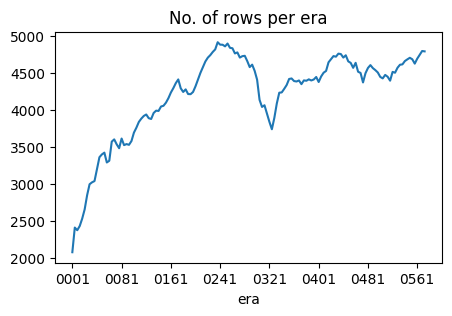

In [10]:
# no of rows per era
train.groupby('era').size().plot(title = "No. of rows per era",figsize = (5,3),xlabel = "era")

<Axes: title={'center': 'Target'}, ylabel='Frequency'>

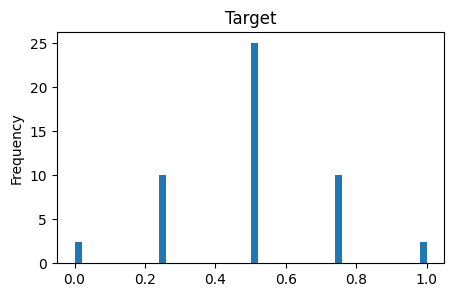

In [ ]:
train["target"].plot(kind = 'hist', figsize = (5,3), bins = 50 , title = "Target",xlabel = "value", density = True)

<Axes: title={'center': 'missing data'}, ylabel='Frequency'>

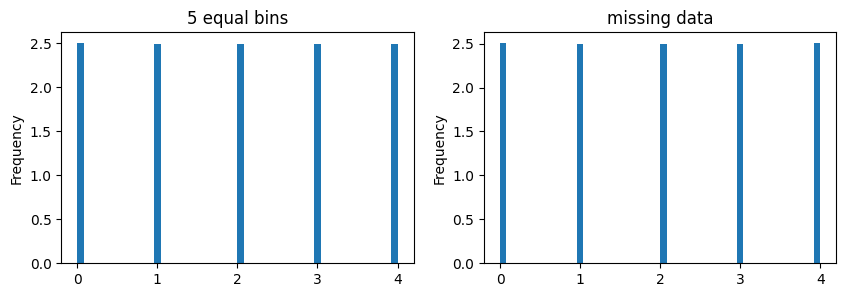

In [23]:
import matplotlib.pyplot as plt
fig ,(ax1 , ax2) = plt.subplots(1,2,figsize = (10,3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era  = train[train["era"] == train["era"].unique()[-1]]
last_era[train.columns[2]].plot(kind = 'hist', density = True , title = "5 equal bins", bins = 50,ax = ax1)
first_era[train.columns[2]].plot(kind = 'hist', title = "missing data", density = True, bins = 50, ax = ax2)

In [10]:
import lightgbm as lgb
model = lgb.LGBMRegressor(n_estimators = 2000 , learning_rate = 0.01 , max_depth = 5, num_leaves = 2**5-1 , colsample_bytree = 0.1)
model.fit(train[feature_metadata["feature_sets"]["medium"]],train["target"]);

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 705
[LightGBM] [Info] Start training from score 0.499979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [11]:
# downloading validation dataset
napi.download_dataset("v4.3/validation_int8.parquet")
validation = pd.read_parquet("v4.3/validation_int8.parquet", columns = ["era","data_type","target"]+ feature_metadata["feature_sets"]["medium"])


In [31]:
validation

,era,data_type,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,validation,0.75,0,0,1,0,3,1,4,...,1,1,1,2,3,0,3,0,2,0
n001e1318d5072ac,0575,validation,0.00,1,4,3,1,3,1,3,...,3,4,3,3,2,2,2,1,2,2
n002a9c5ab785cbb,0575,validation,0.50,2,0,1,1,2,4,3,...,2,4,2,4,3,1,1,1,0,1
n002ccf6d0e8c5ad,0575,validation,0.00,4,0,1,2,1,0,0,...,3,0,1,1,2,2,0,0,2,3
n0051ab821295c29,0575,validation,0.50,0,3,3,0,4,0,4,...,3,0,3,2,3,1,4,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffdb6e40e2f845c,1103,test,NaN,4,0,0,4,3,0,1,...,2,0,4,1,3,4,0,2,2,1
nffe7ab06ef8a5a5,1103,test,NaN,4,0,1,2,1,0,0,...,0,0,0,2,0,0,0,0,2,1
nffeddeb986175f9,1103,test,NaN,2,2,4,1,3,1,2,...,2,0,0,0,2,2,4,1,2,2


In [13]:
# selecting validation dataset out

validation = validation[validation["data_type"] == "validation"]

# downsampling to every fourth era to speed up evaluation
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]


In [26]:
del validation["data_type"]



,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.75,0,0,1,0,3,1,4,0,...,1,1,1,2,3,0,3,0,2,0
n001e1318d5072ac,0575,0.00,1,4,3,1,3,1,3,4,...,3,4,3,3,2,2,2,1,2,2
n002a9c5ab785cbb,0575,0.50,2,0,1,1,2,4,3,4,...,2,4,2,4,3,1,1,1,0,1
n002ccf6d0e8c5ad,0575,0.00,4,0,1,2,1,0,0,3,...,3,0,1,1,2,2,0,0,2,3
n0051ab821295c29,0575,0.50,0,3,3,0,4,0,4,3,...,3,0,3,2,3,1,4,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffbac0ca31b666c,1095,0.50,4,1,4,1,0,3,0,2,...,4,3,4,4,1,4,0,1,0,4
nffbd52f4a0973ef,1095,0.50,1,2,1,0,4,4,3,4,...,2,4,4,4,4,4,4,3,4,0
nffd25d0a9b2e914,1095,0.75,3,3,1,0,0,3,0,2,...,0,3,0,3,2,1,1,0,2,1


In [27]:
validation.era.unique()

array(['0575', '0579', '0583', '0587', '0591', '0595', '0599', '0603',
       '0607', '0611', '0615', '0619', '0623', '0627', '0631', '0635',
       '0639', '0643', '0647', '0651', '0655', '0659', '0663', '0667',
       '0671', '0675', '0679', '0683', '0687', '0691', '0695', '0699',
       '0703', '0707', '0711', '0715', '0719', '0723', '0727', '0731',
       '0735', '0739', '0743', '0747', '0751', '0755', '0759', '0763',
       '0767', '0771', '0775', '0779', '0783', '0787', '0791', '0795',
       '0799', '0803', '0807', '0811', '0815', '0819', '0823', '0827',
       '0831', '0835', '0839', '0843', '0847', '0851', '0855', '0859',
       '0863', '0867', '0871', '0875', '0879', '0883', '0887', '0891',
       '0895', '0899', '0903', '0907', '0911', '0915', '0919', '0923',
       '0927', '0931', '0935', '0939', '0943', '0947', '0951', '0955',
       '0959', '0963', '0967', '0971', '0975', '0979', '0983', '0987',
       '0991', '0995', '0999', '1003', '1007', '1011', '1015', '1019',
      

In [22]:
train.era.unique()

array(['0001', '0005', '0009', '0013', '0017', '0021', '0025', '0029',
       '0033', '0037', '0041', '0045', '0049', '0053', '0057', '0061',
       '0065', '0069', '0073', '0077', '0081', '0085', '0089', '0093',
       '0097', '0101', '0105', '0109', '0113', '0117', '0121', '0125',
       '0129', '0133', '0137', '0141', '0145', '0149', '0153', '0157',
       '0161', '0165', '0169', '0173', '0177', '0181', '0185', '0189',
       '0193', '0197', '0201', '0205', '0209', '0213', '0217', '0221',
       '0225', '0229', '0233', '0237', '0241', '0245', '0249', '0253',
       '0257', '0261', '0265', '0269', '0273', '0277', '0281', '0285',
       '0289', '0293', '0297', '0301', '0305', '0309', '0313', '0317',
       '0321', '0325', '0329', '0333', '0337', '0341', '0345', '0349',
       '0353', '0357', '0361', '0365', '0369', '0373', '0377', '0381',
       '0385', '0389', '0393', '0397', '0401', '0405', '0409', '0413',
       '0417', '0421', '0425', '0429', '0433', '0437', '0441', '0445',
      

In [30]:
last_train_era = int(train["era"].unique()[-1])

In [33]:
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]

In [34]:
validation[~validation["era"].isin(eras_to_embargo)]


,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n002a15bc5575bbb,0579,0.25,3,2,4,2,0,2,0,2,...,4,1,3,1,0,3,2,2,0,2
n00309caaa0f955e,0579,0.50,4,2,0,2,1,2,0,1,...,3,2,0,3,1,2,0,2,0,0
n00576b397182463,0579,0.50,0,1,2,3,0,3,0,2,...,3,2,1,1,4,2,2,4,1,4
n00633405d59c6a1,0579,1.00,4,4,3,2,1,3,4,3,...,2,2,2,3,4,2,4,4,2,1
n008c2eefc8911c7,0579,0.50,2,3,2,1,2,2,0,4,...,2,2,1,0,2,2,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffbac0ca31b666c,1095,0.50,4,1,4,1,0,3,0,2,...,4,3,4,4,1,4,0,1,0,4
nffbd52f4a0973ef,1095,0.50,1,2,1,0,4,4,3,4,...,2,4,4,4,4,4,4,3,4,0
nffd25d0a9b2e914,1095,0.75,3,3,1,0,0,3,0,2,...,0,3,0,3,2,1,1,0,2,1
